In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [45]:
df = pd.read_csv('/home/max/synthetic_transactions.csv', parse_dates=['transaction_date'])

In [46]:
# Вывод первых 5 строк
df.head()

,Unnamed: 0,customer_id,transaction_date,transaction_amount
0,0,CUST_1899,2022-01-01,402.74
1,1,CUST_630,2022-01-01,242.51
2,2,CUST_1258,2022-01-01,62.26
3,3,CUST_119,2022-01-01,477.95
4,4,CUST_2885,2022-01-01,490.45


### Расчет RFM-показателей

In [47]:
# Текущая дата для расчета Recency
current_date = df['transaction_date'].max() + timedelta(days=1)

In [48]:
# Группируем данные по клиентам
rfm_df = df.groupby('customer_id').agg({
    'transaction_date': lambda x: (current_date - x.max()).days,
    'customer_id': 'count',
    'transaction_amount': 'sum'
}).rename(columns={
    'transaction_date': 'Recency',
    'customer_id': 'Frequency',
    'transaction_amount': 'MonetaryValue'
}).reset_index()

In [49]:
# Вывод первых 5 строк RFM-датасета
print("\nRFM-датасет:")
print(rfm_df.head())


RFM-датасет:
  customer_id  Recency  Frequency  MonetaryValue
0      CUST_1       67          9        2823.44
1    CUST_100      163          3        1047.83
2   CUST_1000       20          8        1900.08
3   CUST_1001       29          9        2737.03
4   CUST_1002      105          3         485.44


### Сегментация клиентов

In [50]:
rfm_df['R_quartile'] = pd.qcut(rfm_df['Recency'], q=5, labels=[5, 4, 3, 2, 1])
rfm_df['F_quartile'] = pd.qcut(rfm_df['Frequency'], q=5, labels=[5, 4, 3, 2, 1])
rfm_df['M_quartile'] = pd.qcut(rfm_df['MonetaryValue'], q=5, labels=[5, 4, 3, 2, 1])

In [51]:
# Создаем RFM-сегмент (комбинация R, F, M)
rfm_df['RFM_Segment'] = rfm_df['R_quartile'].astype(str) + rfm_df['F_quartile'].astype(str) + rfm_df['M_quartile'].astype(str)

In [52]:
# Упрощенная сегментация
def get_rfm_segment(row):
    if row['R_quartile'] >= 4 and row['F_quartile'] >= 4 and row['M_quartile'] >= 4:
        return 'Лояльные клиенты'
    if row['R_quartile'] >= 3 and row['F_quartile'] >= 3 and row['M_quartile'] >= 3:
        return 'Потенциально лояльные'
    if row['R_quartile'] >= 2 and row['F_quartile'] >= 2 and row['M_quartile'] >= 2:
        return 'Нуждаются в внимании'
    else:
        return 'Потерянные клиенты'

In [53]:
rfm_df['RFM_Group'] = rfm_df.apply(get_rfm_segment, axis=1)

In [54]:
# Вывод первых 5 строк с сегментами
print("\nRFM-датасет с сегментами:")
print(rfm_df.head())


RFM-датасет с сегментами:
  customer_id  Recency  Frequency  MonetaryValue R_quartile F_quartile  \
0      CUST_1       67          9        2823.44          4          1   
1    CUST_100      163          3        1047.83          3          5   
2   CUST_1000       20          8        1900.08          5          1   
3   CUST_1001       29          9        2737.03          5          1   
4   CUST_1002      105          3         485.44          4          5   

  M_quartile RFM_Segment              RFM_Group  
0          1         411     Потерянные клиенты  
1          3         353  Потенциально лояльные  
2          1         511     Потерянные клиенты  
3          1         511     Потерянные клиенты  
4          5         455       Лояльные клиенты  


### Визуализация результатов

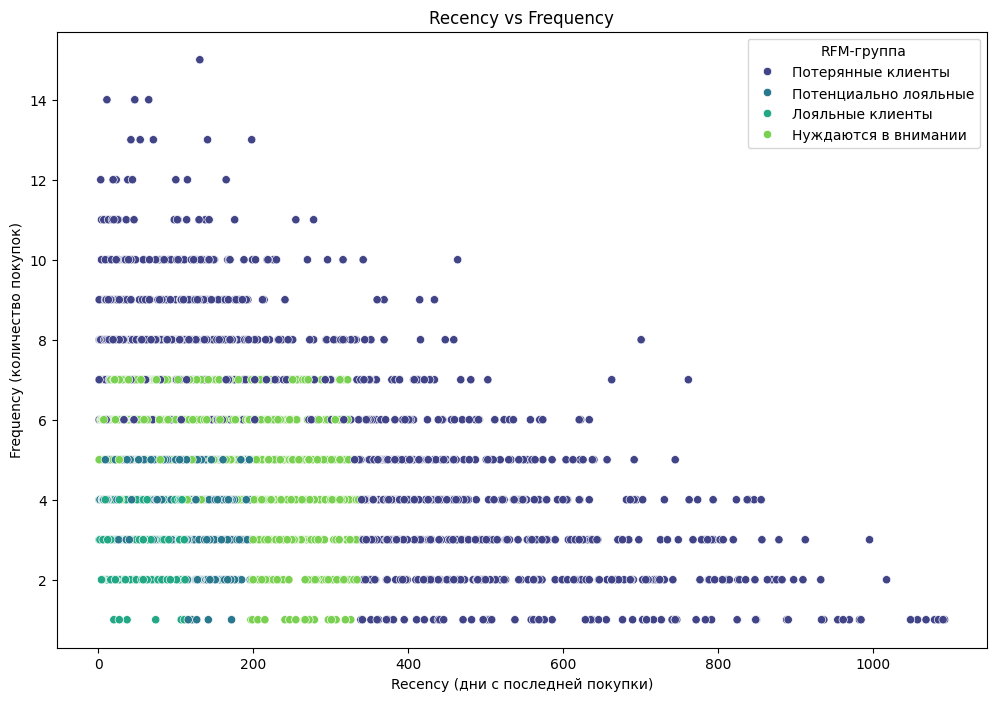

In [55]:
# Распределение клиентов по сегментам
plt.figure(figsize=(12, 8))
sns.scatterplot(data=rfm_df, x='Recency', y='Frequency', hue='RFM_Group', palette='viridis')
plt.title('Recency vs Frequency')
plt.xlabel('Recency (дни с последней покупки)')
plt.ylabel('Frequency (количество покупок)')
plt.legend(title='RFM-группа')
plt.show()

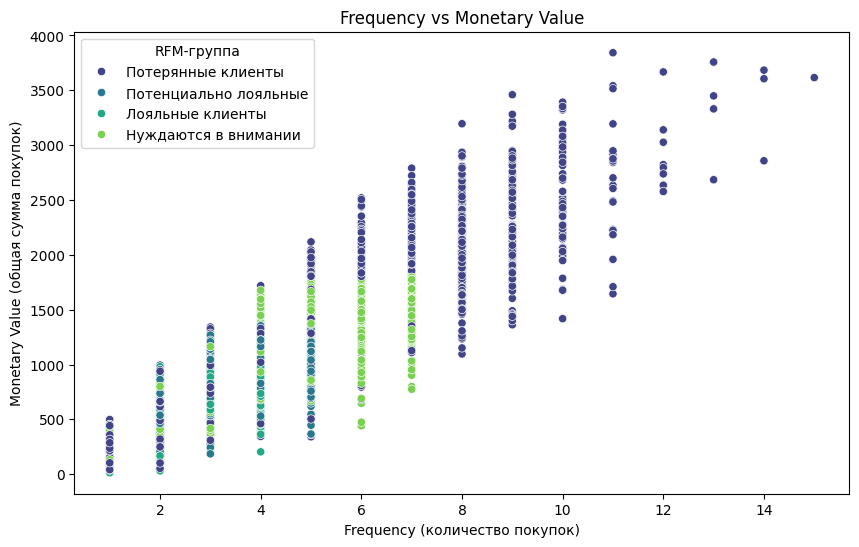

In [56]:
# Scatter plot для Frequency vs Monetary Value
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='Frequency', y='MonetaryValue', hue='RFM_Group', palette='viridis')
plt.title('Frequency vs Monetary Value')
plt.xlabel('Frequency (количество покупок)')
plt.ylabel('Monetary Value (общая сумма покупок)')
plt.legend(title='RFM-группа')
plt.show()

### Анализ и выводы

In [57]:
segment_summary = rfm_df.groupby('RFM_Group').agg({
    'customer_id': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).rename(columns={'customer_id': 'Количество клиентов'})

In [58]:
print("\nАнализ RFM-сегментов:")
print(segment_summary)


Анализ RFM-сегментов:
                       Количество клиентов     Recency  Frequency  \
RFM_Group                                                           
Лояльные клиенты                       256   55.480469   3.082031   
Нуждаются в внимании                   994  172.472837   5.040241   
Потенциально лояльные                  510  107.313725   4.058824   
Потерянные клиенты                    1224  311.368464   5.825980   

                       MonetaryValue  
RFM_Group                             
Лояльные клиенты          677.233906  
Нуждаются в внимании     1236.776559  
Потенциально лояльные     967.377824  
Потерянные клиенты       1559.900074  


#### **Лояльные клиенты**
- **Количество клиентов:** 256
- **Recency (среднее):** 55.48 дней
- **Frequency (среднее):** 3.08 покупок
- **Monetary Value (среднее):** 677.23 руб

**Характеристики:**
- Клиенты совершали покупки относительно недавно (в среднем 55 дней назад).
- Частота покупок умеренная (3.08 покупки).
- Средняя сумма покупок невысокая (677.23 руб).

**Рекомендации:**
- Поддерживайте лояльность этих клиентов с помощью персонализированных предложений и программ лояльности.
- Предложите бонусы или скидки за повторные покупки.
- Увеличьте средний чек, предлагая сопутствующие товары или услуги.

---

#### **Нуждаются в внимании**
- **Количество клиентов:** 994
- **Recency (среднее):** 172.47 дней
- **Frequency (среднее):** 5.04 покупок
- **Monetary Value (среднее):** 1236.78 руб

**Характеристики:**
- Клиенты совершали покупки давно (в среднем 172 дня назад).
- Частота покупок выше средней (5.04 покупки).
- Средняя сумма покупок высокая (1236.78 руб).

**Рекомендации:**
- Эти клиенты важны для бизнеса, но их активность снизилась. Необходимо вернуть их интерес.
- Проведите ретаргетинговую кампанию с персонализированными предложениями.
- Предложите скидки или специальные условия для повторного вовлечения.
- Узнайте причины снижения активности (например, через опросы или обратную связь).

---

#### **Потенциально лояльные клиенты**
- **Количество клиентов:** 510
- **Recency (среднее):** 107.31 дней
- **Frequency (среднее):** 4.06 покупок
- **Monetary Value (среднее):** 967.38 руб

**Характеристики:**
- Клиенты совершали покупки недавно (в среднем 107 дней назад).
- Частота покупок умеренная (4.06 покупки).
- Средняя сумма покупок выше средней (967.38 руб).

**Рекомендации:**
- Эти клиенты имеют потенциал стать лояльными. Усильте взаимодействие с ними.
- Предложите программы лояльности или бонусы за частые покупки.
- Увеличьте частоту покупок, напоминая о новых поступлениях или акциях.
- Создайте персонализированные предложения на основе их предпочтений.

---

#### **Потерянные клиенты**
- **Количество клиентов:** 1224
- **Recency (среднее):** 311.37 дней
- **Frequency (среднее):** 5.83 покупок
- **Monetary Value (среднее):** 1559.90 руб

**Характеристики:**
- Клиенты совершали покупки очень давно (в среднем 311 дней назад).
- Частота покупок высокая (5.83 покупки).
- Средняя сумма покупок самая высокая (1559.90 руб).

**Рекомендации:**
- Эти клиенты были очень ценными, но их активность прекратилась. Необходимо вернуть их.
- Проведите ретаргетинговую кампанию с акцентом на их прошлые покупки.
- Предложите значительные скидки или специальные условия для возврата.
- Узнайте причины ухода (например, через опросы или анализ оттока).

---

#### **Общие выводы:**
1. **Лояльные клиенты** составляют небольшую, но важную часть базы. Их нужно удерживать и увеличивать их средний чек.
2. **Нуждающиеся в внимании клиенты** — это ключевая группа, которая может принести значительный доход, если их вернуть.
3. **Потенциально лояльные клиенты** имеют высокий потенциал для увеличения их лояльности и частоты покупок.
4. **Потерянные клиенты** — это бывшие активные покупатели, которые приносили высокий доход. Их возврат может значительно увеличить прибыль.

---

#### **Дополнительные рекомендации:**
- **Персонализация:** Используйте данные о покупках для создания персонализированных предложений.
- **Автоматизация коммуникаций:** Настройте автоматические email- или SMS-рассылки для разных сегментов.
- **Анализ причин оттока:** Проведите анализ, чтобы понять, почему клиенты перестали совершать покупки.
- **Программы лояльности:** Внедрите программы, которые поощряют частые покупки и увеличивают средний чек.